In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [3]:
from tqdm import tqdm
import copy
import numpy as np

In [4]:
import torch
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Custom files.
from model import DiffusionModel
from training import get_config, ImgDataset, evaluate_model, demo
from diffusion import diffusion_loss
import federated_learning as fl

import utils

In [6]:
# Define dataset and settings.
# dataset_name = 'svhn'
# dataset_name = 'cifar_10'
dataset_name = 'fashion_mnist'

# Define distribution settings.
num_clients = 12
beta = 0.1 # [0.1, 0.5, 5]
num_local_epochs = 3

client_data_dir = os.path.join('./client_data/', dataset_name + '_beta_{}'.format(beta))

save_dir = os.path.join('./output/diffusion_fedavg', dataset_name + '_beta_{}'.format(beta))
os.makedirs(save_dir, exist_ok=True)

In [7]:
data_config, train_config = get_config(dataset_name)
print(data_config)
print(train_config)

# Data config.
channels = data_config['channels']
batch_size = data_config['batch_size']
train_transform = data_config['train_transform']
test_transform = data_config['test_transform']

# Training config.
lr = train_config['lr']
timesteps = train_config['timesteps']
num_rounds = train_config['rounds']
num_local_epochs = train_config['local_epochs']
eta = train_config['eta']
save_interval = train_config['save_interval']

{'img_size': 32, 'channels': 3, 'batch_size': 512, 'train_transform': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=[0.5], std=[0.5])
), 'test_transform': Compose(
    ToTensor()
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=[0.5], std=[0.5])
)}
{'lr': 0.0002, 'timesteps': 500, 'epochs': 300, 'rounds': 300, 'local_epochs': 3, 'ema_decay': 0.998, 'eta': 1.0, 'save_interval': 50}


In [8]:
# Data.
data_dir = os.path.join('../datasets/', dataset_name)

# Centralized testset for global model evaluation.
test_dir = os.path.join(data_dir, 'test')
test_data = ImgDataset(test_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

In [9]:
# Define client data.
client_loaders = []
for client_idx in range(num_clients):
    data_dir = os.path.join(client_data_dir, str(client_idx))
    dataset = ImgDataset(data_dir, transform=train_transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
    client_loaders.append(data_loader)

{0: 'Ankle boot', 1: 'Bag', 2: 'Coat', 3: 'Dress', 4: 'Pullover', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'T-shirt top', 9: 'Trouser'}


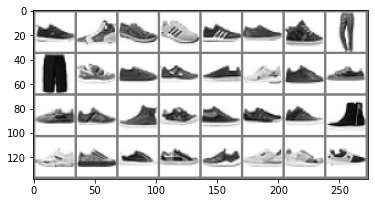

In [10]:
client_loader = client_loaders[0]

# Useful for image generation later. Just to check which images are generated.
label_idx_dict = client_loader.dataset.label_idx_dict
idx_label_dict = {idx: label for label, idx in label_idx_dict.items()}
print(idx_label_dict)

num_classes = len(idx_label_dict)

# Print a few images.
dataiter = iter(client_loader)
images, labels = dataiter.next()
utils.show_img_tensor(torchvision.utils.make_grid(images[:32]))

In [11]:
# Global model.
glob_model = DiffusionModel().to(device)

# For logging model performance.
performance_dict, performance_log = dict(), dict()
metric_keys = ['g_train_loss', 'g_test_loss']
for metric in metric_keys:
    performance_dict[metric] = utils.MeanMetric()
    performance_log[metric] = list()

# performance_dict, performance_log = utils.get_performance_loggers(metric_keys)

In [12]:
# Automatic resuming from checkpoint.
log_path = os.path.join(save_dir, 'performance_log.pickle')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
start_round = len(performance_log[metric_keys[0]])

if start_round > 0:
    glob_model.load_state_dict(torch.load(os.path.join(save_dir, 'g_r_{}.pth'.format(start_round))))

In [13]:
glob_w = glob_model.state_dict()

optim_args = {'lr': lr}

for round_no in range(start_round, num_rounds):
    utils.print_separator(text='Round: {} / {}'.format(round_no + 1, num_rounds))
                
    # Local training.
    glob_model.train()
    client_updates = dict()
    for client_idx in range(num_clients):  
        print('client:', client_idx)
        client_loader = client_loaders[client_idx]
        
        # Local training.
        client_update = fl.local_update_fedavg(glob_model, client_loader, test_loader, num_local_epochs, optim_args)
        
        # For weighted averaging.
        client_updates.setdefault('local_w', list()).append(client_update['local_w'])
        client_updates.setdefault('num_samples', list()).append(client_update['num_samples'])
        
        # Logging client performance.
        performance_log.setdefault('c_{}_train_loss'.format(client_idx), list()).append(client_update['train_loss'])
        performance_log.setdefault('c_{}_test_loss'.format(client_idx), list()).append(client_update['test_loss'])
            
    # Model aggregation.
    glob_w = fl.weighted_averaging(client_updates['local_w'], client_updates['num_samples'])
    glob_model.load_state_dict(glob_w)
    
    # Evaluate global model on local datasets.
    for client_idx in range(num_clients):
        g_train_loss = evaluate_model(glob_model, client_loader, diffusion_loss, tqdm_desc='g_train_loss')
        performance_dict['g_train_loss'].update_state(g_train_loss)
        
    # Average local performace of global model.
    performance_log['g_train_loss'].append(performance_dict['g_train_loss'].result())
    performance_dict['g_train_loss'].reset_state()
    
    # Evaluate global model on global testset.
    g_test_loss = evaluate_model(glob_model, test_loader, diffusion_loss, tqdm_desc='g_test_loss')
    performance_log['g_test_loss'].append(g_test_loss)
    
#     for key in sorted(performance_log.keys()):
#         print(key, ': ',  performance_log[key][-1])
    
    for key in sorted(metric_keys):
        print(key, ': ',  performance_log[key][-1])
    
    # Save global model.
    if (round_no + 1) % save_interval == 0:
        torch.save(glob_model.state_dict(), os.path.join(save_dir, 'g_r_{}.pth'.format(round_no + 1)))
        utils.save_pickle(log_path, performance_log)

    # Save client models only in the last round. To save space.
    if round_no + 1 == num_rounds:
        for client_idx in range(num_clients):
            local_state_dict = client_updates['local_w'][client_idx]
            torch.save(local_state_dict, os.path.join(save_dir, 'c_{}_r_{}.pth'.format(client_idx, round_no + 1)))


 ==================== Round: 251 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 16.75it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.76it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.88it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.65it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.80it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.18it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.32it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.87it/s]


g_test_loss :  0.014164961082860828
g_train_loss :  0.016741807976116737

 ==================== Round: 252 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.38it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.26it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.14it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.23it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.03it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 17.93it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.33it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.89it/s]


g_test_loss :  0.014568634843453766
g_train_loss :  0.017299957278495034

 ==================== Round: 253 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.94it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.28it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.46it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.67it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.39it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.79it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.95it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


g_test_loss :  0.01467396323569119
g_train_loss :  0.017454647334913413

 ==================== Round: 254 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.24it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.07it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.54it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.64it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.58it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.05it/s]


g_test_loss :  0.014692240580916404
g_train_loss :  0.017466762491191425

 ==================== Round: 255 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.63it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.25it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.79it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.97it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.68it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.61it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.48it/s]


g_test_loss :  0.014730382757261396
g_train_loss :  0.017511459703867634

 ==================== Round: 256 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.39it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.48it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.82it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.10it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


g_test_loss :  0.014728007931262254
g_train_loss :  0.01750890735226373

 ==================== Round: 257 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.92it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.31it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.41it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.94it/s]


g_test_loss :  0.014735878305509686
g_train_loss :  0.017519571539014577

 ==================== Round: 258 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.48it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.96it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.67it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.36it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.02it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.98it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.92it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


g_test_loss :  0.01474976995959878
g_train_loss :  0.017521474401776985

 ==================== Round: 259 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.68it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.07it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.81it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.21it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.72it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.73it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.98it/s]


g_test_loss :  0.014762765821069479
g_train_loss :  0.017535589169710875

 ==================== Round: 260 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.24it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.36it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.49it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 17.51it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.63it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.73it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.50it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


g_test_loss :  0.014745387015864253
g_train_loss :  0.017514761025086045

 ==================== Round: 261 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.17it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 16.27it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.33it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.87it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.63it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.37it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.03it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


g_test_loss :  0.01475595855154097
g_train_loss :  0.017511679775392017

 ==================== Round: 262 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.36it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.85it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.17it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.66it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.56it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 17.30it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.67it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.62it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.28it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.48it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.98it/s]


g_test_loss :  0.014775505941361188
g_train_loss :  0.01754235120800634

 ==================== Round: 263 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.92it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 17.92it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 17.48it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.15it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.74it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.48it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.52it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.24it/s]


g_test_loss :  0.014787616673856974
g_train_loss :  0.01755001797961692

 ==================== Round: 264 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.25it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.77it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 16.64it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.42it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.53it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.48it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


g_test_loss :  0.014798293169587851
g_train_loss :  0.017561167369907097

 ==================== Round: 265 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.36it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.78it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.91it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.64it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.13it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


g_test_loss :  0.014792560413479806
g_train_loss :  0.017556947904328504

 ==================== Round: 266 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.59it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.39it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.42it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.21it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.74it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.75it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.94it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


g_test_loss :  0.014776219381019473
g_train_loss :  0.017535926308482885

 ==================== Round: 267 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.74it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.32it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.38it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.41it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.30it/s]


g_test_loss :  0.014780500764027238
g_train_loss :  0.01756122289225459

 ==================== Round: 268 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.64it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.42it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.32it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.41it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.14it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.32it/s]


g_test_loss :  0.014766285801306367
g_train_loss :  0.017536558412636318

 ==================== Round: 269 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.36it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.51it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.33it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.80it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.04it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.67it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.17it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


g_test_loss :  0.014783891849219799
g_train_loss :  0.017555642345299324

 ==================== Round: 270 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.33it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.30it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.61it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.26it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.62it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.41it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 21.04it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


g_test_loss :  0.014790696837008
g_train_loss :  0.01757905239549776

 ==================== Round: 271 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.70it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.03it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.66it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.79it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.89it/s]


g_test_loss :  0.014779756544157863
g_train_loss :  0.017544618947431444

 ==================== Round: 272 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.89it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.95it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.28it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.70it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.16it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.98it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.18it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.97it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 18.92it/s]


g_test_loss :  0.014802986616268754
g_train_loss :  0.017590394228075942

 ==================== Round: 273 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.36it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.86it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.99it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.38it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.06it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.76it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.21it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.77it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.61it/s]


g_test_loss :  0.014789405930787324
g_train_loss :  0.01755795016263922

 ==================== Round: 274 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.16it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.65it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.06it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.16it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.06it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 18.24it/s]


g_test_loss :  0.01481481371447444
g_train_loss :  0.017590621610482537

 ==================== Round: 275 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.09it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.39it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.65it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.86it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.38it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.95it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.48it/s]


g_test_loss :  0.014813469490036368
g_train_loss :  0.017579743079841136

 ==================== Round: 276 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.01it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.42it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.68it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.09it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.92it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.83it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.25it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.69it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.38it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


g_test_loss :  0.01483079930767417
g_train_loss :  0.017596301436424256

 ==================== Round: 277 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.91it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.65it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.88it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.71it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.38it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.99it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.66it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.30it/s]


g_test_loss :  0.014807252027094365
g_train_loss :  0.01758263132845362

 ==================== Round: 278 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.39it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.81it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.88it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.60it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.67it/s]


g_test_loss :  0.014826450729742646
g_train_loss :  0.01759839927156766

 ==================== Round: 279 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.70it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.75it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.64it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.10it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


g_test_loss :  0.014819921180605888
g_train_loss :  0.01759865144267678

 ==================== Round: 280 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.75it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.05it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.75it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


g_test_loss :  0.01482430174946785
g_train_loss :  0.017613136380289992

 ==================== Round: 281 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.62it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.61it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.21it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.49it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


g_test_loss :  0.01481433711014688
g_train_loss :  0.017599786771461366

 ==================== Round: 282 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.41it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.82it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.61it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.42it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.61it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.48it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.68it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.66it/s]


g_test_loss :  0.01481467909179628
g_train_loss :  0.017621503196035823

 ==================== Round: 283 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.42it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.73it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.17it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.29it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.64it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.79it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


g_test_loss :  0.014837779244408012
g_train_loss :  0.017616281704977154

 ==================== Round: 284 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.13it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.30it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.22it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.27it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.74it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.11it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.26it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


g_test_loss :  0.014848419930785894
g_train_loss :  0.017606992879882453

 ==================== Round: 285 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.89it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.48it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.30it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.01it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.65it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 21.04it/s]


g_test_loss :  0.014845330407842994
g_train_loss :  0.017631962569430473

 ==================== Round: 286 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.79it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.95it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.42it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.77it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.76it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


g_test_loss :  0.01482688430696726
g_train_loss :  0.017609637696295977

 ==================== Round: 287 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.29it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.71it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.71it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.01it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.78it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:01<00:00, 19.99it/s]


g_test_loss :  0.014818116463720799
g_train_loss :  0.017608563027655084

 ==================== Round: 288 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.63it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.25it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 21.08it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.81it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.86it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


g_test_loss :  0.014813157357275486
g_train_loss :  0.017604737216606735

 ==================== Round: 289 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.51it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.57it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.41it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.50it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.89it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.41it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


g_test_loss :  0.014833829645067454
g_train_loss :  0.017606606148183344

 ==================== Round: 290 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.88it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.55it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.26it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.27it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.52it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 21.01it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 18.84it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.32it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.69it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


g_test_loss :  0.014839037181809544
g_train_loss :  0.01761966133490205

 ==================== Round: 291 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.29it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.63it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.87it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.69it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.90it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


g_test_loss :  0.014826718997210265
g_train_loss :  0.017616681413104136

 ==================== Round: 292 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.68it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.48it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.70it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.17it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.43it/s]


g_test_loss :  0.014827268244698644
g_train_loss :  0.01761204996146262

 ==================== Round: 293 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.47it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.48it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.42it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.73it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.75it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


g_test_loss :  0.014849947625771165
g_train_loss :  0.017634358598540227

 ==================== Round: 294 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.62it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.48it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.63it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.99it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.48it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.66it/s]


g_test_loss :  0.014826682861894369
g_train_loss :  0.01762008780303101

 ==================== Round: 295 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.36it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.98it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.39it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.56it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.51it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.25it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.37it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.19it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.52it/s]


g_test_loss :  0.014823564793914557
g_train_loss :  0.017606153292581438

 ==================== Round: 296 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.69it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 20.00it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.14it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.30it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.20it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.82it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.07it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.48it/s]


g_test_loss :  0.014820879185572266
g_train_loss :  0.017614481660226982

 ==================== Round: 297 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.73it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.69it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.05it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.30it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.48it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.34it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.64it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.61it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


g_test_loss :  0.014811145002022385
g_train_loss :  0.017598325557385882

 ==================== Round: 298 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.66it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.01it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.61it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.59it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.50it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.45it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.38it/s]


g_test_loss :  0.014840141031891107
g_train_loss :  0.01762578383398553

 ==================== Round: 299 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.28it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.43it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.32it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.33it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:01<00:00, 19.37it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.40it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.82it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.36it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.46it/s]


g_test_loss :  0.014821251062676311
g_train_loss :  0.017596506311868626

 ==================== Round: 300 / 300 ====================

client: 0


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


client: 1


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.29it/s]


client: 2


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.77it/s]


client: 3


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.63it/s]


client: 4


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


client: 5


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


client: 6


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.83it/s]


client: 7


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


client: 8


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.64it/s]


client: 9


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.42it/s]


client: 10


local_test_loss: 100%|██████████████████████████| 20/20 [00:00<00:00, 20.15it/s]


client: 11


g_test_loss: 100%|██████████████████████████████| 20/20 [00:00<00:00, 20.60it/s]


g_test_loss :  0.014821024565026163
g_train_loss :  0.017616537399590015


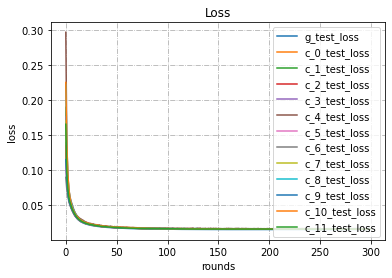

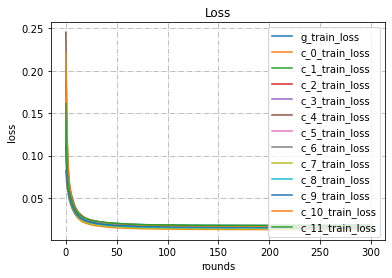

In [14]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'test_loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'rounds'
loss_plot_config['labels'] = ['g_test_loss'] + ['c_{}_test_loss'.format(client_idx) for client_idx in range(num_clients)]
loss_plot_config['attributes'] = ['g_test_loss'] + ['c_{}_test_loss'.format(client_idx) for client_idx in range(num_clients)]
utils.save_history_plot(performance_log, loss_plot_config)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'train_loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'rounds'
loss_plot_config['labels'] = ['g_train_loss'] + ['c_{}_train_loss'.format(client_idx) for client_idx in range(num_clients)]
loss_plot_config['attributes'] = ['g_train_loss'] + ['c_{}_train_loss'.format(client_idx) for client_idx in range(num_clients)]
utils.save_history_plot(performance_log, loss_plot_config)

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.36it/s]


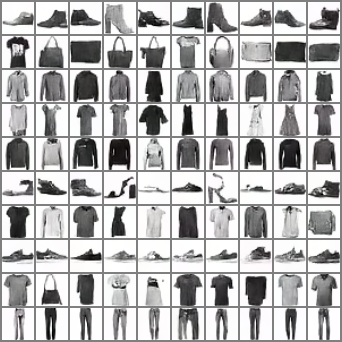

In [15]:
# Reload saved global model for generation.
glob_model = DiffusionModel().to(device)
glob_model.load_state_dict(torch.load(os.path.join(save_dir, 'g_r_{}.pth'.format(num_rounds))))

img_folder = os.path.join(save_dir, 'images')
os.makedirs(img_folder, exist_ok=True)

# Generate and save image.
img_path = os.path.join(img_folder, 'g_final.png')
demo(glob_model, img_path, timesteps, eta)

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.92it/s]


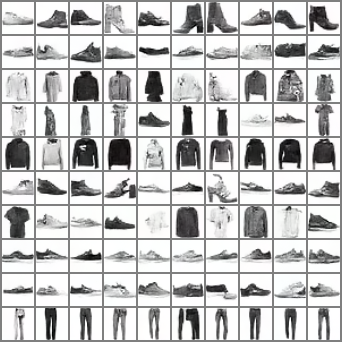

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.91it/s]


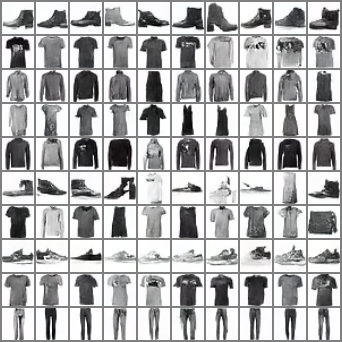

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.90it/s]


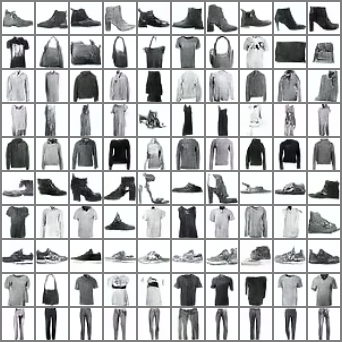

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.91it/s]


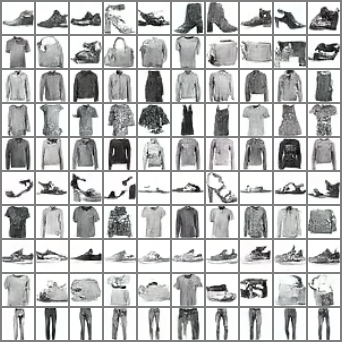

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.91it/s]


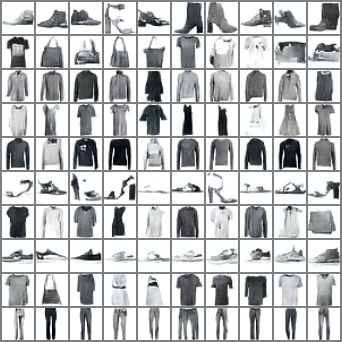

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.89it/s]


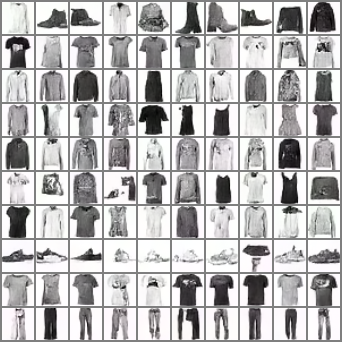

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.89it/s]


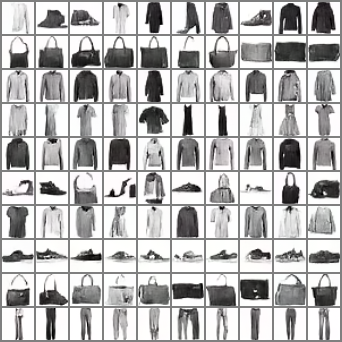

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.89it/s]


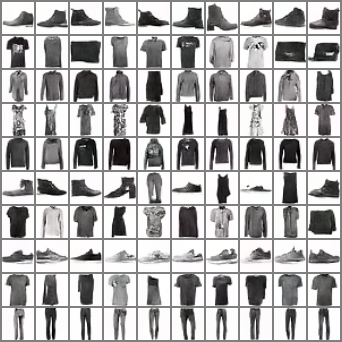

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.86it/s]


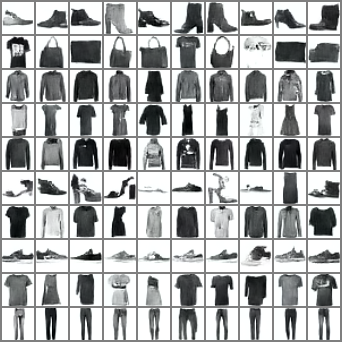

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.87it/s]


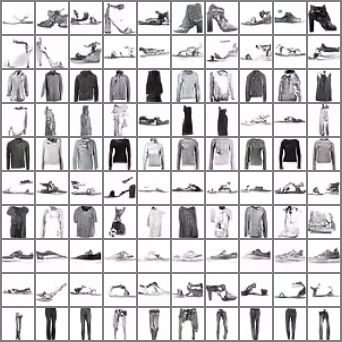

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.86it/s]


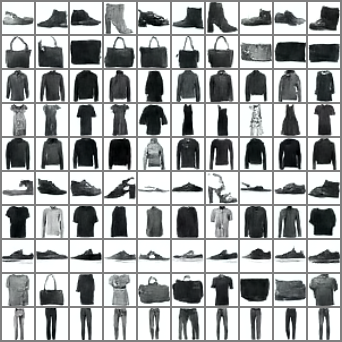

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.67it/s]


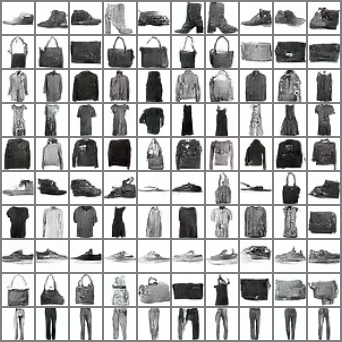

In [16]:
# Reload saved client models for generation.
local_model = DiffusionModel().to(device)
for client_idx in range(num_clients):
    local_model.load_state_dict(torch.load(os.path.join(save_dir, 'c_{}_r_{}.pth'.format(client_idx, num_rounds))))
    img_path = os.path.join(img_folder, 'c_{}_final.png'.format(client_idx))
    demo(local_model, img_path, timesteps, eta)